In [91]:
import math
import dill
import datetime
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter

In [92]:
# Загрузка исходных данных в датасеты из файлов csv

df_sessions = pd.read_csv('ga_sessions.csv', dtype={'session_id':'str', 'client_id': 'str', 'visit_date':'str', 'visit_time': 'str',\
    'visit_number':'int', 'utm_source': 'str', 'utm_medium':'str', 'utm_campaign': 'str', 'utm_medium':'str','utm_campaign':'str',\
    'utm_adcontent': 'str', 'utm_keyword':'str', 'device_category': 'str', 'device_os':'str', 'device_brand':'str', \
    'device_model': 'str', 'device_screen_resolution':'str', 'device_browser': 'str', 'geo_country':'str','geo_city':'str'})
df_hits = pd.read_csv('ga_hits.csv', usecols=['session_id', 'event_action'], dtype={'session_id':'str', 'event_action': 'str'})

##EDA

###Data Cleaning

In [93]:
# Подготовка датасета с целевой переменной: приведение целевой переменной в бинарный вид и группировка действий в рамках одной 
# сессии

success = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click', \
           'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

In [94]:
index = list(df_hits[df_hits.event_action.isin(success)].index)
df_hits.loc[index, 'event_action_bin'] = 1
df_hits.event_action_bin = df_hits.event_action_bin.fillna(0)

In [95]:
stats_hits = df_hits.groupby(['session_id'], as_index=False)[['event_action_bin']].max()

In [96]:
# Формирование единого датафрейма с данными

df_full = pd.merge(left=df_sessions, right=stats_hits, on='session_id', how='inner') 
df_full.head(3)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_bin
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0


In [97]:
# Приведение типу целевой переменной к целому 
df_full['event_action_bin'] = df_full['event_action_bin'].astype(int)
df_full['event_action_bin'].dtype

dtype('int32')

In [98]:
df_full.event_action_bin.value_counts()

0    1681952
1      50314
Name: event_action_bin, dtype: int64

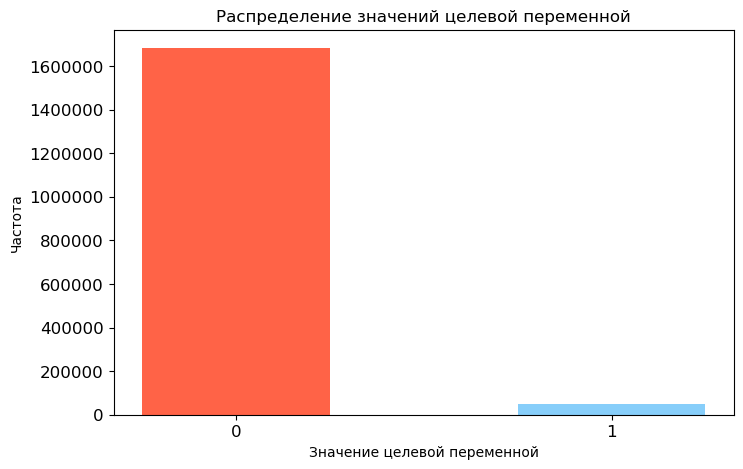

In [101]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_full['event_action_bin'].unique(), df_full['event_action_bin'].value_counts(), width=0.5, color=['tomato', 'lightskyblue'])
ax.set_xlabel('Значение целевой переменной')
ax.set_ylabel('Частота')
ax.set_title('Распределение значений целевой переменной')
ax.tick_params(axis='both', labelsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

### Совершение целевого действия происходит примерно в 2,9% сессий, что говорит о дисбалансе классов целевой переменной

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int32 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  event_action_bin          int32 
dtypes: int32(2), object(17)
memory usage: 251.1+ MB


### Данные представлены 16 признаками (столбцы session_id и client_id имеют уникальные значения и не имеют ценности для модели и будут использованы только для рассчета статистик и построения графиков), 15 категориальных и 1 числовой.

In [10]:
# Проверка датасета на отсутствие дублирующих записей

df_full = df_full.drop_duplicates()
print('Количество дублирующихся записей - ', len(df_full[df_full.duplicated()].values)) 

Количество дублирующихся записей -  0


In [11]:
# Вывод информации о размере датасета и пропущенных данных

df_full.shape

(1732266, 19)

<AxesSubplot:>

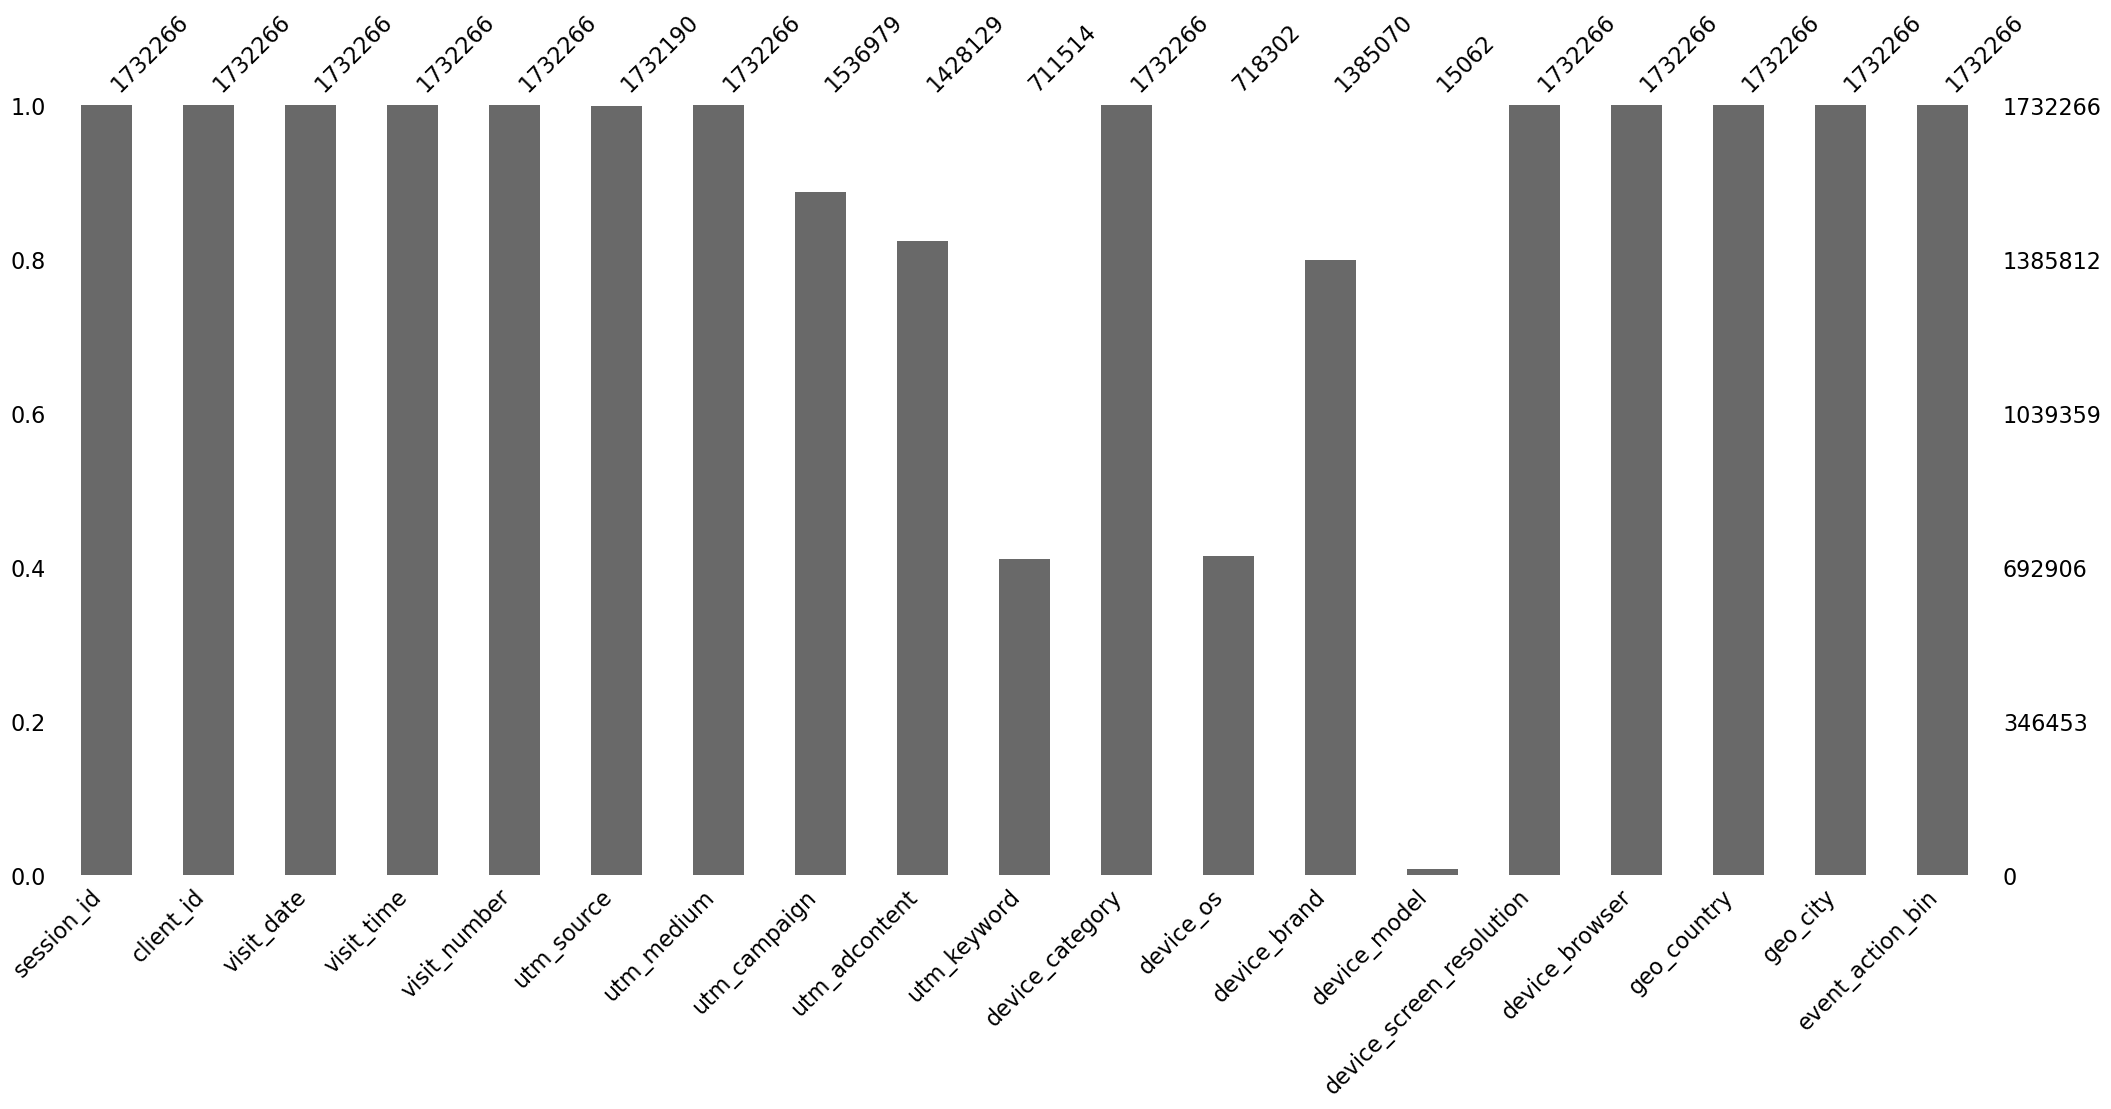

In [12]:
msno.bar(df_full)

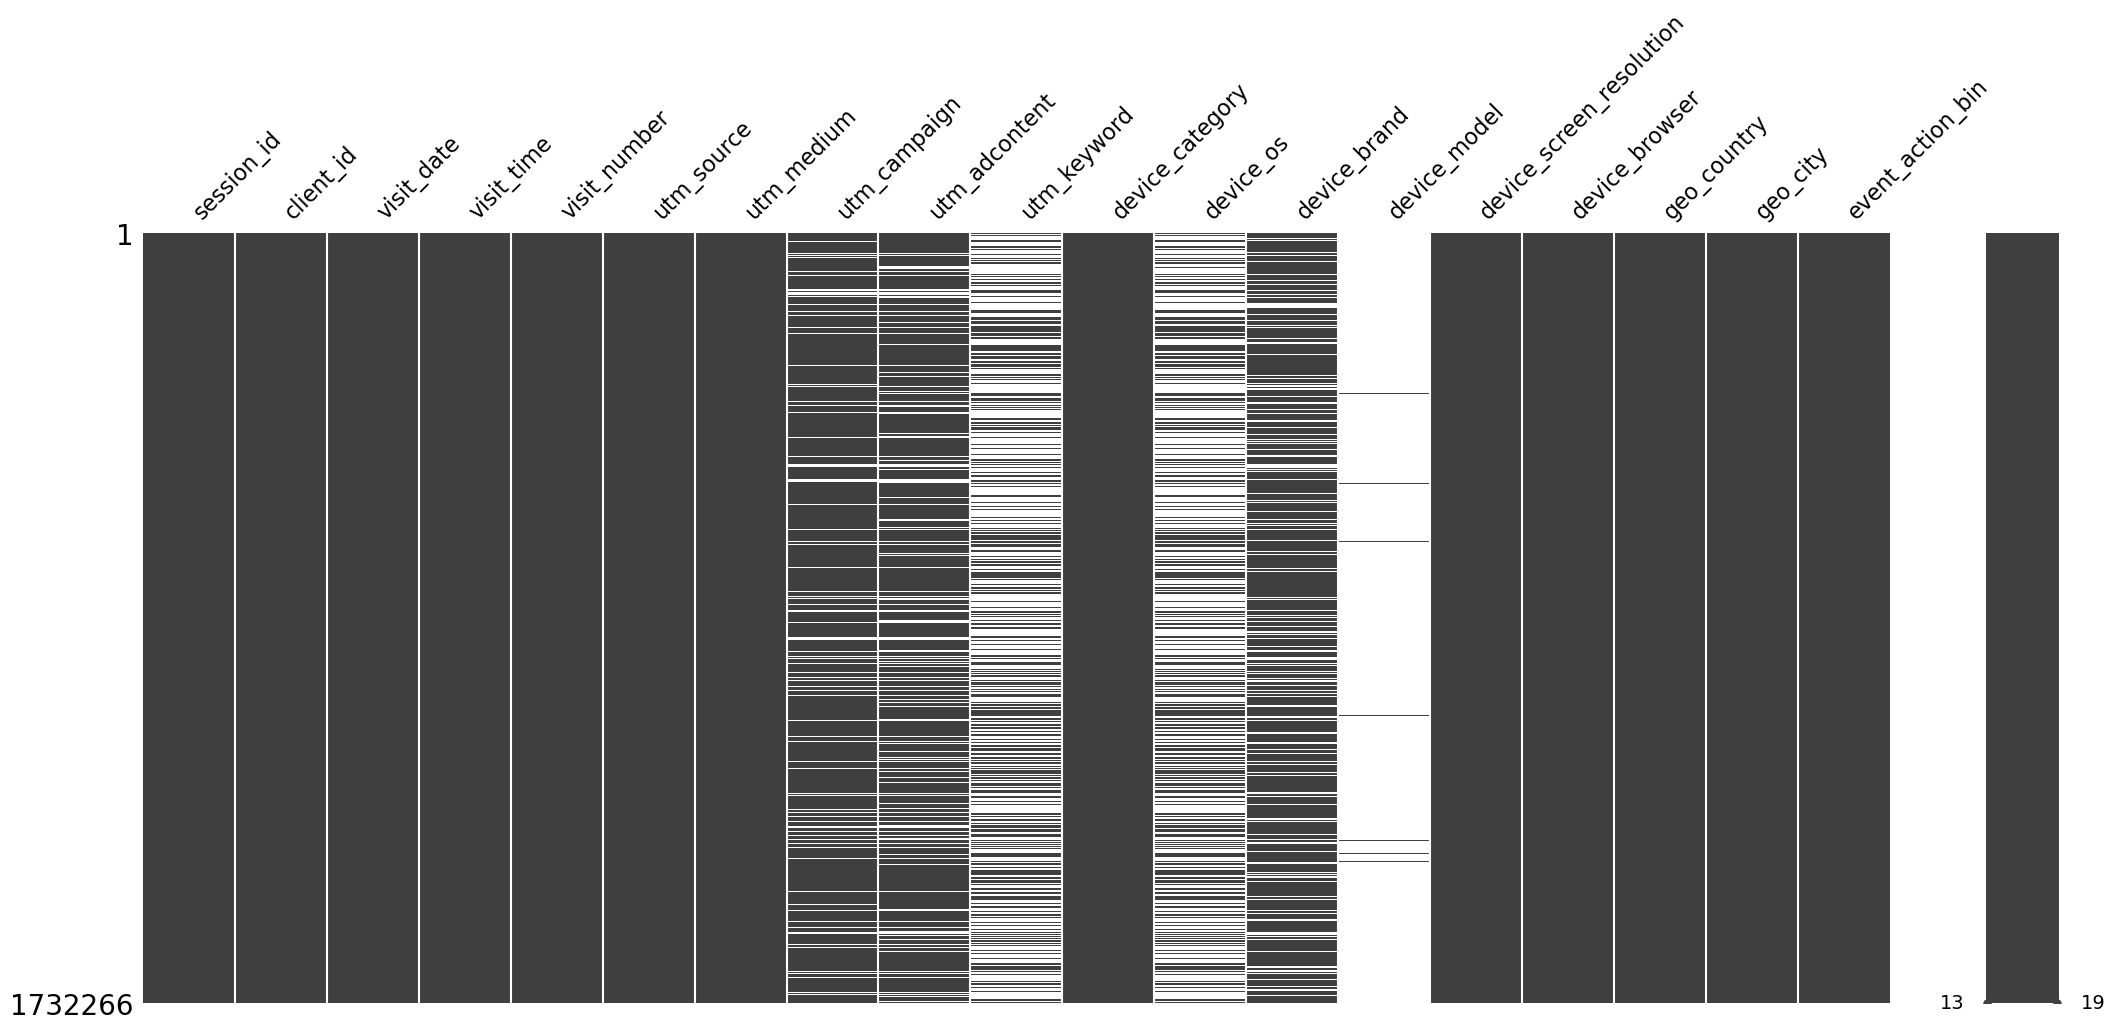

In [13]:
msno.matrix(df_full);

In [14]:
# Определение количества полностью заполненных объектов, процент и количество пропущенных значений в признаках:

def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
print_useful_rows_info(df_full)
missing_values = ((df_full.isna().sum() / len(df_full)) * 100).sort_values(ascending=False)
print(f'Процент пропущенных значений:\n' + f'{missing_values}')

Количество полностью заполненных объектов из всей выборки: 13829
Процент полностью заполненных объектов из всей выборки: 0.8
Процент пропущенных значений:
device_model                99.130503
utm_keyword                 58.925823
device_os                   58.533966
device_brand                20.042880
utm_adcontent               17.557177
utm_campaign                11.273500
utm_source                   0.004387
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_action_bin             0.000000
dtype: float64


In [15]:
def missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    for i in range(0, len(missing_values)):
        if missing_values[i] > 0:
            print(missing_values.index[i], '-', df.loc[:, missing_values.index[i]].isna().sum())
print('Количество пропущенных значений в столбцах:')
missing_values(df_full)

Количество пропущенных значений в столбцах:
device_model - 1717204
utm_keyword - 1020752
device_os - 1013964
device_brand - 347196
utm_adcontent - 304137
utm_campaign - 195287
utm_source - 76


In [16]:
df_full.nunique()

session_id                  1732266
client_id                   1320704
visit_date                      226
visit_time                    85032
visit_number                    533
utm_source                      280
utm_medium                       55
utm_campaign                    406
utm_adcontent                   280
utm_keyword                    1192
device_category                   3
device_os                        13
device_brand                    200
device_model                    104
device_screen_resolution       4947
device_browser                   55
geo_country                     159
geo_city                       2389
event_action_bin                  2
dtype: int64

In [17]:
# Удаление столбца с 99% пропусков

df_full = df_full.drop(columns=['device_model'])


In [18]:
# Замена пропусков в марке устройства и отсутствующих данных

df_full.loc[df_full['device_os'] == 'Macintosh', 'device_brand'] = 'Apple'
df_full.device_brand = df_full.device_brand.fillna('unknown')

for column in df_full.columns:
    df_full.loc[:, column] = df_full.loc[:, column].apply(lambda x: 'unknown' if x == '(not set)' else x)

In [19]:
# Восстановление отсутствующих записей об операционной системе устройства

def os_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1]], as_index=False)[df.columns[2]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[2]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) & \
            (df[df.columns[1]] == stats.loc[i, df.columns[1]])].index)
            df.loc[index_list, df.columns[2]] = stats.loc[i, df.columns[2]]
        except:
            pass
    df[df.columns[2]][df[df.columns[2]].isna()] = 'unknown'
    return df[df.columns[2]]

df_full.device_os = os_recovery(df_full.loc[:, ['device_brand', 'device_category', 'device_os']])

In [20]:
# Удаление строк датафрейма с 3-мя и более отсутствующими UTM-метками, а также отсутствующими значениями utm_source

utm_nan = list(df_full[(df_full.utm_keyword.isna()) & (df_full.utm_campaign.isna()) & (df_full.utm_adcontent.isna())].index) + \
list(df_full[df_full.utm_source.isna()].index)
df_full = df_full.drop(axis=0, index=utm_nan)
df_full.shape

(1611275, 18)

In [21]:
# Разбиение признаков utm-меток на группы и заполнение пропусков признаков utm-меток модой для соответствующей группы

def utm_recovery(df):
    stats = df.groupby([df.columns[0], df.columns[1], df.columns[2]], as_index=False)[df.columns[3]].agg(pd.Series.mode)
    for i in range(0, len(stats)):
        try:
            index_list = list(df[(df[df.columns[3]].isna()) & (df[df.columns[0]] == stats.loc[i, df.columns[0]]) & \
            (df[df.columns[1]] == stats.loc[i, df.columns[1]]) & (df[df.columns[2]] == stats.loc[i, df.columns[2]])].index)
            df.loc[index_list, df.columns[3]] = stats.loc[i, df.columns[3]]
        except:
            pass
    df[df.columns[3]][df[df.columns[3]].isna()] = 'unknown'
    return df[df.columns[3]]

df_full.utm_campaign = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_adcontent', 'utm_campaign']])
df_full.utm_adcontent = utm_recovery(df_full.loc[:, ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent']])
df_full.utm_keyword = utm_recovery(df_full.loc[:, ['utm_adcontent', 'utm_medium', 'utm_campaign', 'utm_keyword']])

In [22]:
# Вывод количества пропусков в оставшихся признаках

print_useful_rows_info(df_full)
print('Количество пропущенных значений в столбцах:')
missing_values(df_full)

Количество полностью заполненных объектов из всей выборки: 1611275
Процент полностью заполненных объектов из всей выборки: 100.0
Количество пропущенных значений в столбцах:


In [23]:
# Проверка на наличие близких значений в столбце device_browser

df_full.device_browser.unique()

array(['Chrome', 'Samsung Internet', 'Safari', 'YaBrowser',
       'Android Webview', 'Safari (in-app)', 'Opera', 'Firefox', 'Edge',
       'helloworld', 'Android Runtime', 'UC Browser',
       'Instagram 208.0.0.32.135 Android', 'Mozilla Compatible Agent',
       'unknown', 'Mozilla', 'Opera Mini', 'Coc Coc', 'Android',
       'Instagram 216.1.0.21.137 Android', '[FBAN', 'Internet Explorer',
       'Puffin', 'MRCHROME', 'com.vk.vkclient',
       'Instagram 209.0.0.21.119 Android', 'Instagram 202.0.0.23.119',
       'Instagram 213.0.0.29.120 Android', 'Android Browser', 'Maxthon',
       'Instagram 207.0.0.28.118', 'Instagram 199.1.0.34.119 Android',
       'Instagram 192.0.0.37.119', 'Amazon Silk',
       'Instagram 194.0.0.36.172 Android', 'Instagram 216.0.0.12.135',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Android', 'Instag

In [24]:
# Обработка и объединение подобных или аналогичных браузеров, замена невалидных значений

df_full['device_browser'] = df_full['device_browser'].apply(lambda x: x.split(' ')[0].lower()).replace({'helloworld':'other', \
'[fban':'other', 'mrchrome':'chrome', 'MyApp':'other', 'nokiax2-02':'other', 'nokia501':'other', 'com.zhiliaoapp.musically':\
                                                                                                'other', 'threads':'other'})
df_full.device_browser.unique()

array(['chrome', 'samsung', 'safari', 'yabrowser', 'android', 'opera',
       'firefox', 'edge', 'other', 'uc', 'instagram', 'mozilla',
       'unknown', 'coc', 'internet', 'puffin', 'com.vk.vkclient',
       'maxthon', 'amazon', 'myapp', 'netfront', 'mt6735_td', 'konqueror',
       'seamonkey', 'iron'], dtype=object)

###Data Visualization

In [25]:
# Вывод статистик по посещаемости сайта

stat_session_id = df_full.groupby(['visit_date'], as_index=False)[['session_id']].count()
stat_session_id = stat_session_id.rename(columns={'session_id': 'session_count'}).sort_values(by='visit_date', ascending=True)
stat_session_id.head(3)

,visit_date,session_count
0,2021-05-19,703
1,2021-05-21,815
2,2021-05-22,699


In [26]:
# Вывод статистик о совершении целевого действия

stat_event_action = df_full.groupby(['visit_date'], as_index=False)[['event_action_bin']].sum()
stat_event_action = stat_event_action.rename(columns={'event_action_bin': 'count_success_event_action'}).sort_values(by='visit_date', ascending=True)
stat_event_action.head(3)

,visit_date,count_success_event_action
0,2021-05-19,50
1,2021-05-21,0
2,2021-05-22,10


In [27]:
# Вывод статистик конверсии посещения сайта в целевое действие

stat_event_conversion = df_full.groupby(['visit_date'], as_index=False).agg({'event_action_bin': 'mean'})
stat_event_conversion = stat_event_conversion.rename(columns={'event_action_bin': 'conversion'})
stat_event_conversion.head(3)

,visit_date,conversion
0,2021-05-19,0.071124
1,2021-05-21,0.000000
2,2021-05-22,0.014306


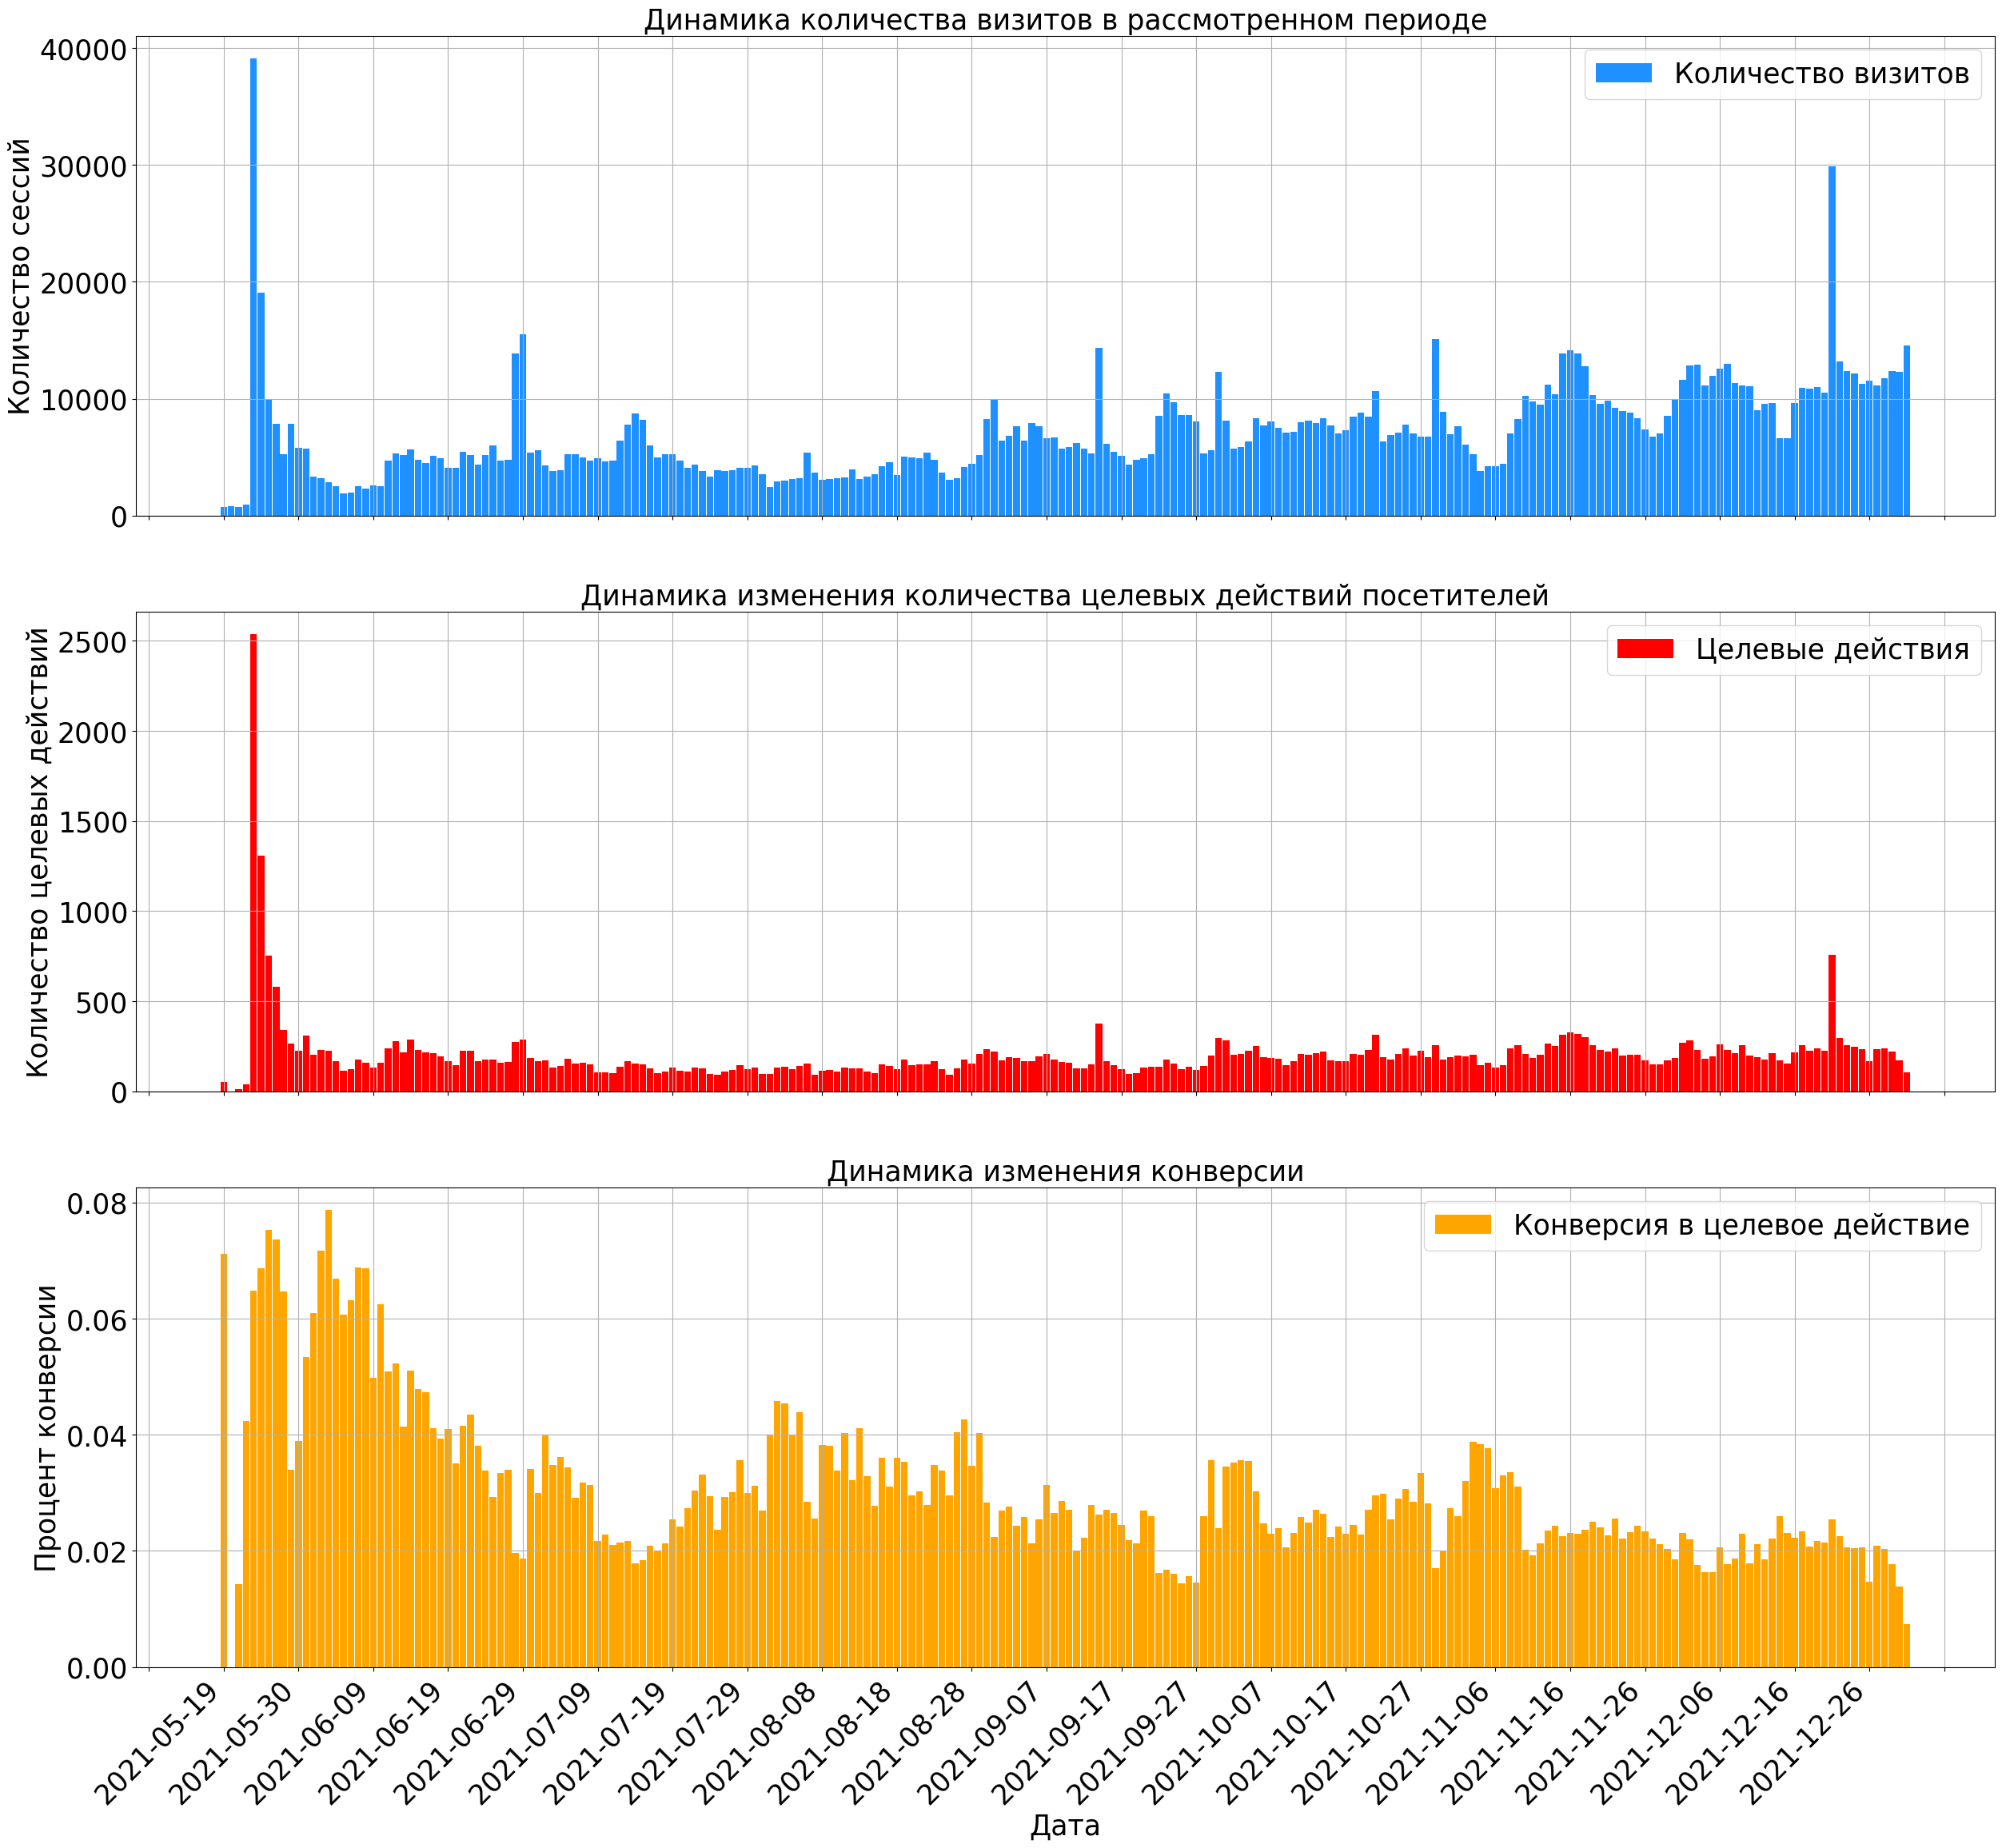

In [88]:
# Графики динамики визитов, совершения целевых действий и конверсии


fig, ax = plt.subplots(3, 1, figsize=(30, 30))
ax[0].bar(stat_session_id['visit_date'], stat_session_id['session_count'], width=0.9, color='dodgerblue', \
                                                                            label='Количество визитов')
ax[1].bar(stat_event_action['visit_date'], stat_event_action['count_success_event_action'], width=0.9, color='red', \
                                                                            label='Целевые действия')
ax[2].bar(stat_event_conversion['visit_date'], stat_event_conversion['conversion'], width=0.9, color='orange', \
                                                                            label='Конверсия в целевое действие')

ax[0].legend(loc='upper right', fontsize = 25)
ax[1].legend(loc='upper right', fontsize = 25)
ax[2].legend(loc='upper right', fontsize = 25)

ax[0].set_title('Динамика количества визитов в рассмотренном периоде', fontsize = 25)
ax[1].set_title('Динамика изменения количества целевых действий посетителей', fontsize = 25)
ax[2].set_title('Динамика изменения конверсии', fontsize = 25)

ax[0].set_xlabel('Дата')
ax[1].set_xlabel('Дата')
ax[2].set_xlabel('Дата', fontsize = 25)

ax[0].set_ylabel('Количество сессий', fontsize = 25)
ax[1].set_ylabel('Количество целевых действий', fontsize = 25)
ax[2].set_ylabel('Процент конверсии', fontsize = 25)

ax[0].tick_params(axis='both', labelsize=25)
ax[1].tick_params(axis='both', labelsize=25)
ax[2].tick_params(axis='both', labelsize=25)

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))    
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(10)) 
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(10)) 

ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.autofmt_xdate(rotation=45);

### Из графиков видно, что в динамике количество посещений растет со временем, при этом количество целевых действий примерно одинаковое (за исключением летних месяцев и отднльных дат и недель, что может быть связано с успешностью проводимой рекламной компании в указанном периоде).
### График целевых действий в определенной степени повторяет график сессий, но резкий рост в определенные даты целевых действий менее выраженный, что видно из графика конверсии (резких скачков на них нет). Если эти скачки связаны с дополнительными рекламмными компаниями в этот период, это говорит о том, что рекламная компания привлекла дополнительных клиентов, но не увеличила заинтересованность привлеченных клиентов, о чем и говорит график конверсии.
### В целом можно сказать, что в динамике уровень конверсии снижается.

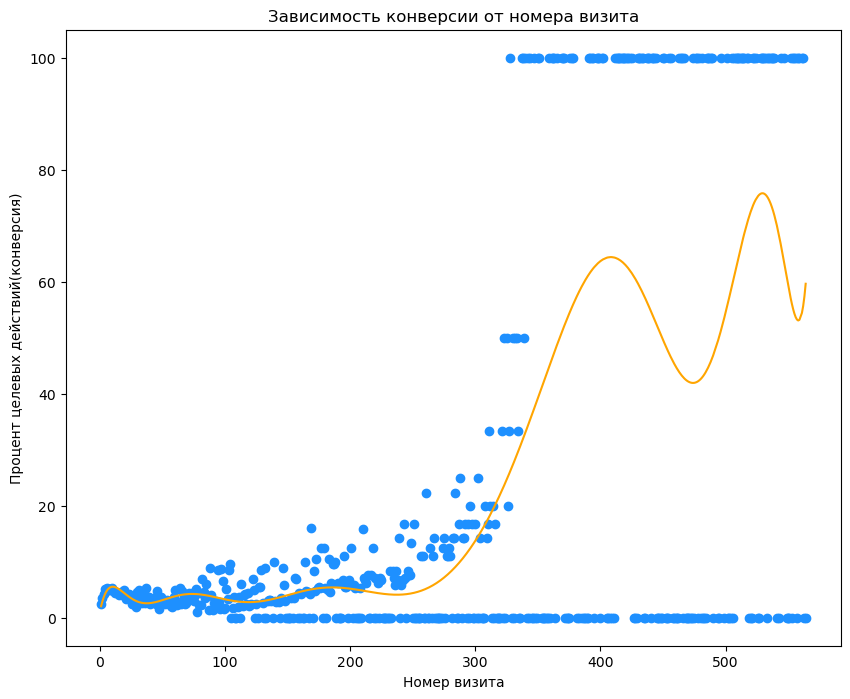

In [28]:
# Вывод зависимости конверсии в целевое действие от порядкового номера визита

stats1 = df_full.groupby(['event_action_bin', 'visit_number'], as_index=False)[['session_id']].count()
stats1 = stats1.rename(columns={'session_id': 'count'}).sort_values(by='visit_number', ascending=True)
p_set = set()
for elem in stats1['visit_number']:
    p_set.add(elem)
    
chart_coords1 = []

for i in p_set:
    
    chart_coords1.append((i, (sum(stats1.event_action_bin[stats1['visit_number'] == i] * \
                                 stats1['count'][stats1['visit_number'] == i])) / stats1['count'][stats1['visit_number'] == i].sum() * 100))
d1 = pd.DataFrame(chart_coords1, columns=['x', 'y'])
plt.figure(figsize=(10, 8))
plt.scatter(d1['x'], d1['y'], color='dodgerblue')

z = np.polyfit (d1['x'], d1['y'], 13)
p = np.poly1d (z)
plt.plot(d1['x'], p(d1['x']), color='orange')

plt.xlabel('Номер визита')
plt.ylabel('Процент целевых действий(конверсия)')
plt.title('Зависимость конверсии от номера визита');

### Из графика можно сделать вывод, что в целом конверсия растет с увеличением порядкового номера посещения сайта, но на разных интервалах наблюдается как рост, так и снижение.

In [34]:
# Создание функции для рассчета статистик признаков

def feature_stats(df, feature):
    stats = df.groupby([feature], as_index=False)[['session_id']].count()
    stats = stats.rename(columns={'session_id': 'count'}).sort_values(by='count', ascending=False)
    return stats

In [105]:
# Создание функции для построения графика распределения

def distribution_graph(stats, feature, figsize, feature_sence, n_first_fiatures):
    if n_first_fiatures != 'all':
        stats = stats.head(n_first_fiatures)
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(stats[feature], stats['count'], width=0.9, color=['orange', 'dodgerblue'])
    ax.set_xlabel('Название ' + feature_sence, fontsize = 20)
    ax.set_ylabel('Частота', fontsize = 20)
    ax.set_title('Распределение ' + feature_sence, fontsize = 20)
    ax.tick_params(axis='both', labelsize=14)
    fig.autofmt_xdate(rotation=45);
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [106]:
# Статистики для столбца, содержащего значения utm-метки с доп.информацией

stats_adcontent = feature_stats(df_full, 'utm_adcontent')
stats_adcontent.head(5)

,utm_adcontent,count
45,JNHcPlZPxEMWDnRiyoBf,935408
244,vCIpmpaGBnIQhyYNkXqp,179438
263,xhoenQgDQsgfEPYNPwKO,104381
82,PkybGvWbaqORmxjNunqZ,59038
56,LLfCasrxQzJIyuldcuWy,18138


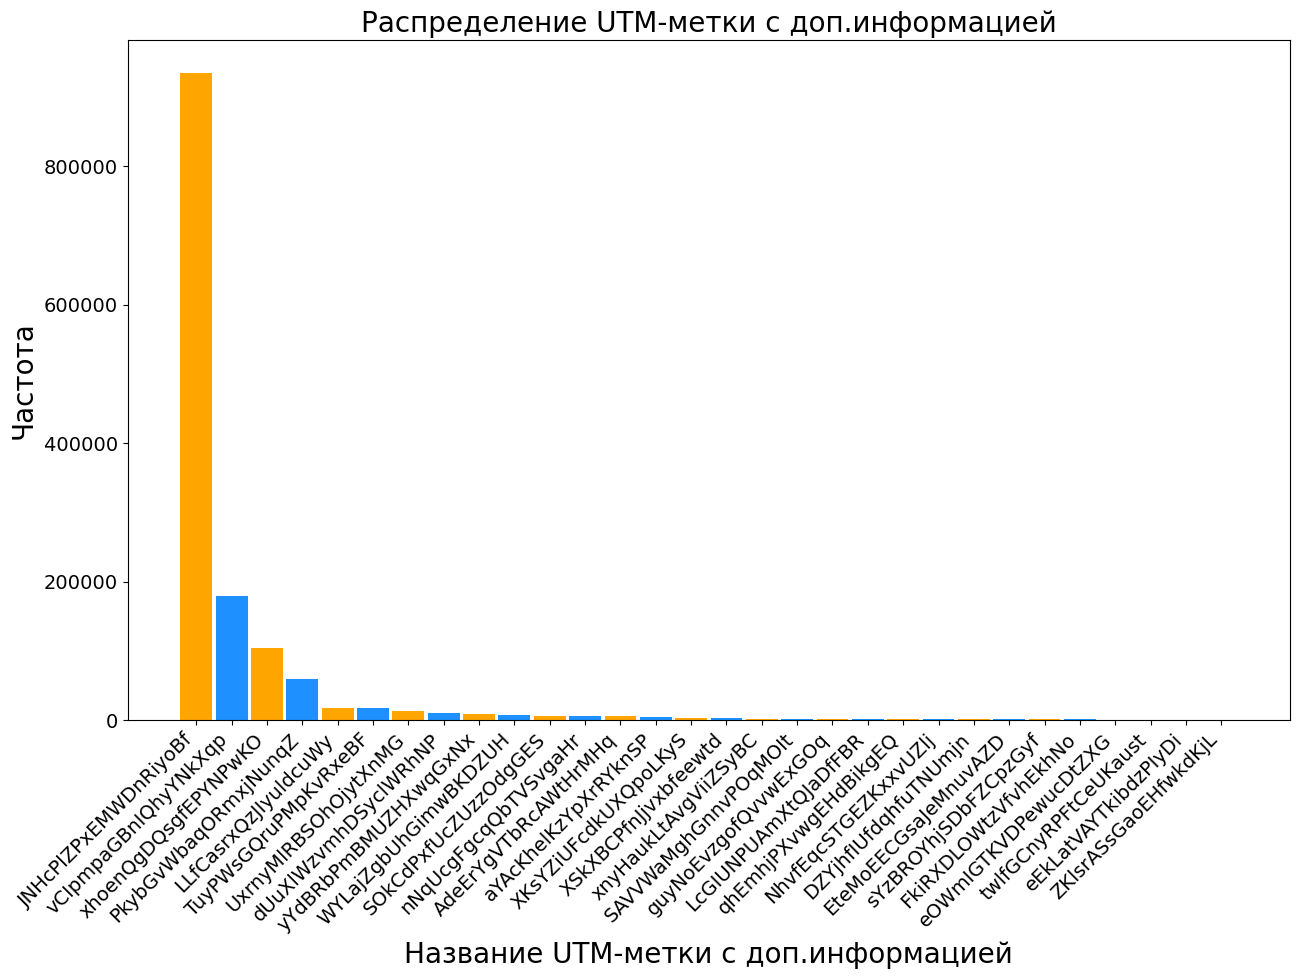

In [107]:
# График распределения для utm-меткок с доп.информацией (30 наиболее часто встречающихся)

distribution_graph(stats_adcontent, 'utm_adcontent', (15, 10), 'UTM-метки с доп.информацией', 30)

### UTM-метки с доп.информацией распределены неравномерно, более 60% представлено одним классом, еще 4 значения встречаются в 12,5%, 7,5%, 7,5% и примерно 4% случаев. Остальные значения встречаются в 1% случаев и менее (в разрезе отдельных значений).

In [108]:
# Статистики для столбца, содержащего значения utm-метки с названием компании

stats_campaign = feature_stats(df_full, 'utm_campaign')
stats_campaign.head(5)

,utm_campaign,count
87,LTuZkdKfxRGVceoWkVyg,422992
84,LEoPHuyFvzoNfnzGgfcd,321286
39,FTjNLDyTrXaWYgZymFkV,234950
255,gecBYcKZCPMcVYdSSzKP,133247
192,XHNUiSKKGTEpSAlaVMFQ,23750


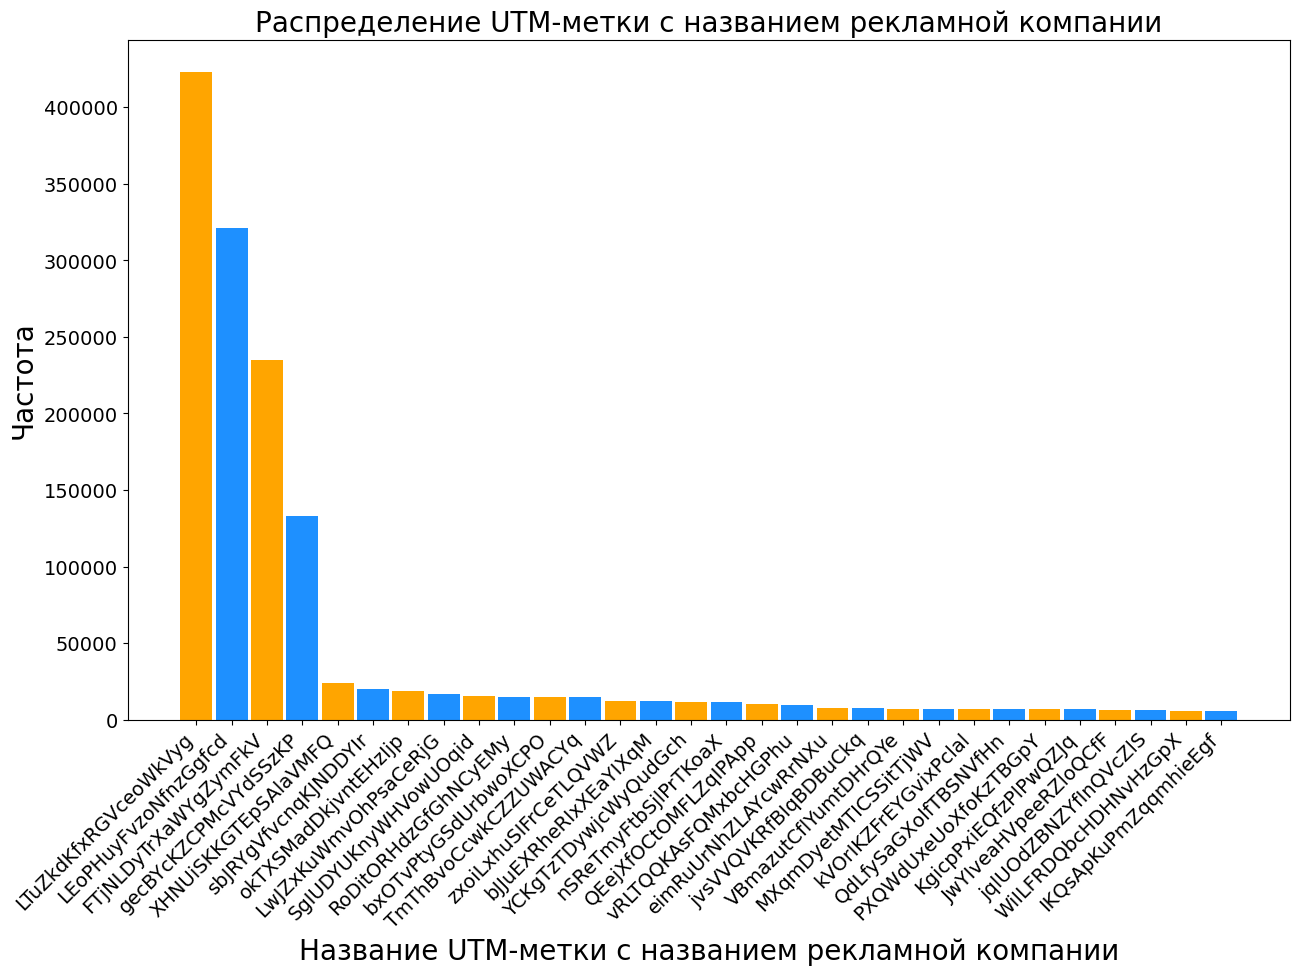

In [109]:
# График распределения для utm-меткок с доп.информацией (30 наиболее часто встречающихся)

distribution_graph(stats_campaign, 'utm_campaign', (15, 10), 'UTM-метки с названием рекламной компании', 30)

### UTM-метки с названием рекламной компании распределены неравномерно, более 25% представлено одним классом, еще 4 значения встречаются примерно в 20%, 15%, 9% и примерно 4% случаев. Остальные значения встречаются менее чем в 2% случаев (в разрезе отдельных значений).

In [49]:
# Статистики для столбца, содержащего значения utm-метки о источнике трафика

stats_source = feature_stats(df_full, 'utm_source')
stats_source.head(5)

,utm_source,count
148,ZpYIoDJMcFzVoPFsHGJL,552555
175,fDLlAcSmythWSCVMvqvL,277060
209,kjsLglQLzykiRbcDiGcD,202790
77,MvfHsxITijuriZxsqZqt,175831
155,bByPQxmDaMXgpHeypKSM,85671


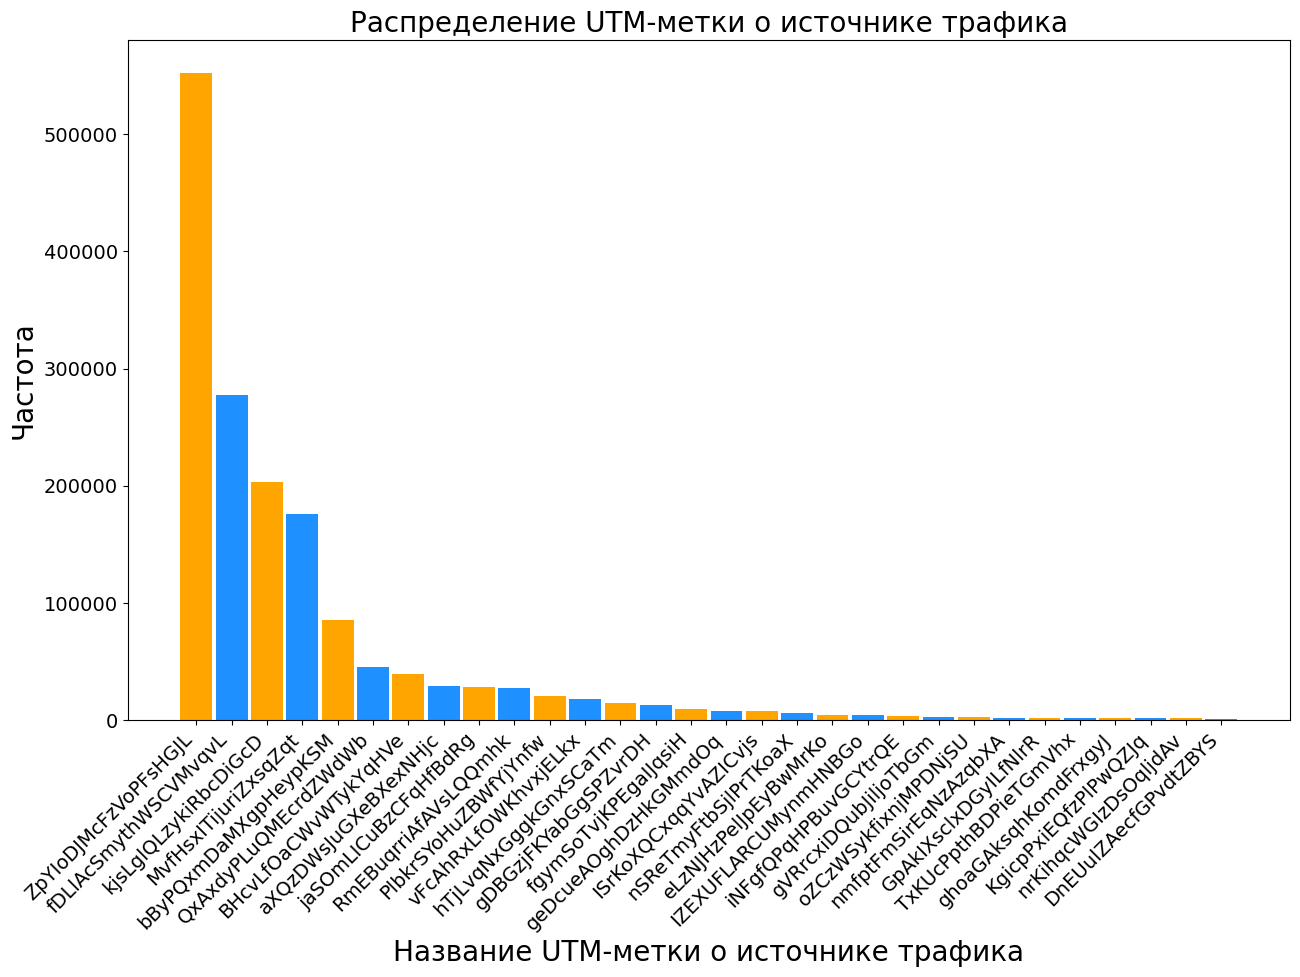

In [110]:
# График распределения для utm-меткок о источнике трафика(30 наиболее часто встречающихся)

distribution_graph(stats_source, 'utm_source', (15, 10), 'UTM-метки о источнике трафика', 30)

### UTM-метки об источнике трафика распределены неравномерно, более 33% представлено одним классом, еще 4 значения встречаются примерно в 18%, 12,5%, 11,5% и 6% случаев. Остальные значения встречаются менее чем в 3% случаев (в разрезе отдельных значений).

In [51]:
# Статистики для столбца, содержащего значения utm-метки о типе канала

stats_medium = feature_stats(df_full, 'utm_medium')
stats_medium.head(5)

,utm_medium,count
3,banner,525206
11,cpc,283165
0,(none),277060
12,cpm,229791
37,referral,132166


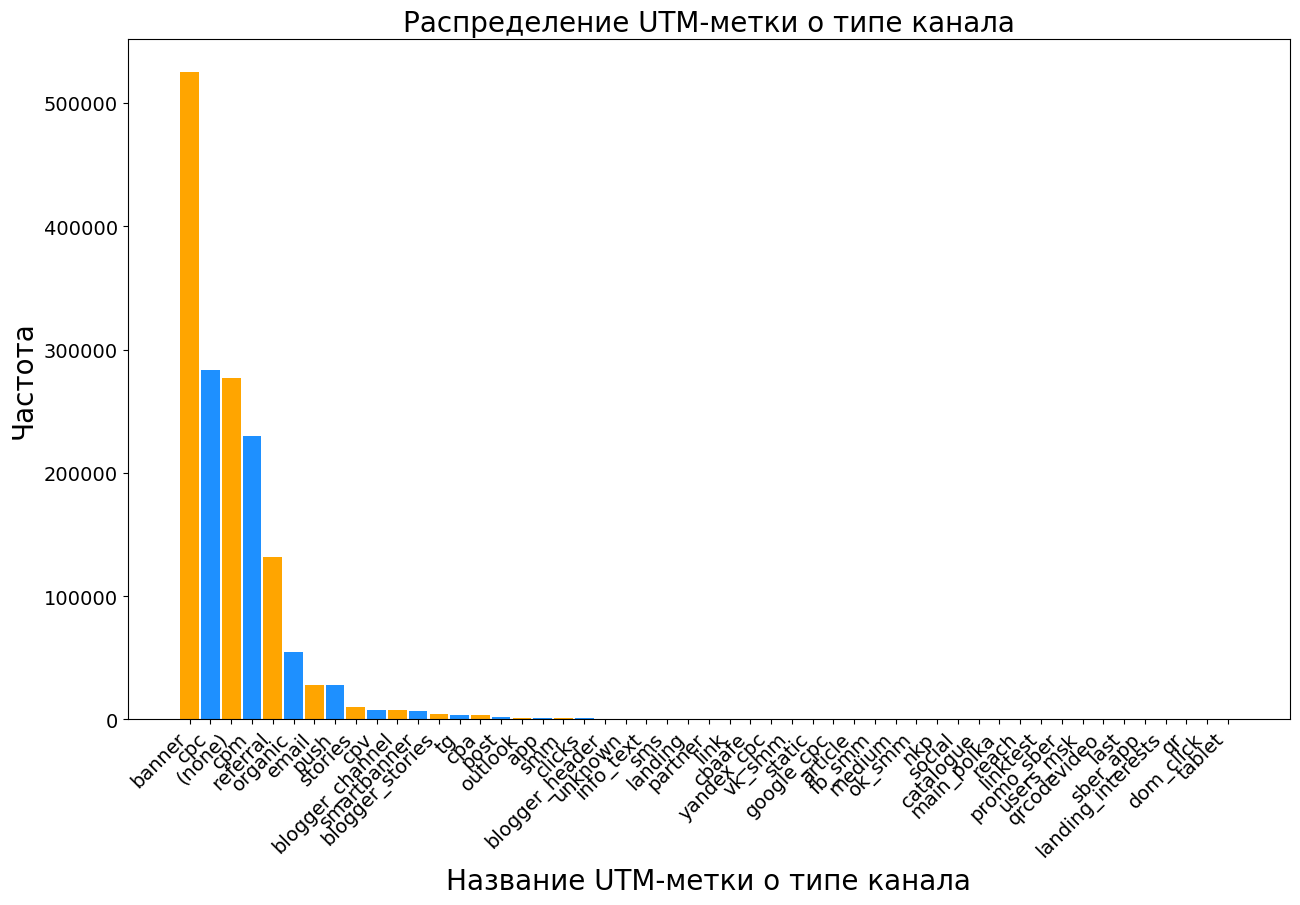

In [111]:
# График распределения для utm-меткок о типе канала

distribution_graph(stats_medium, 'utm_medium', (15, 10), 'UTM-метки о типе канала', 'all')

### UTM-метки о типе канала также распределены неравномерно, более 33% представлено одним классом, еще 7 значения встречаются примерно в 18%, 17.5%, 15%, 7,5%, 4% и 4% случаев. Остальные значения встречаются в 1% и менее случаев (в разрезе отдельных значений).

In [53]:
# Статистики для столбца, содержащего значения utm-метки с ключевым словом

stats_keyword = feature_stats(df_full, 'utm_keyword')
stats_keyword.head(5)

,utm_keyword,count
957,puhZPIYqKXeFPaUviSjo,1060801
1058,unknown,52903
313,NUYvxgBEIYqMlnpeDTIM,49442
747,hAmNSZmQkKQKAjZEGlgb,39987
456,UKNBOHebRIIsQRsjNKay,37854


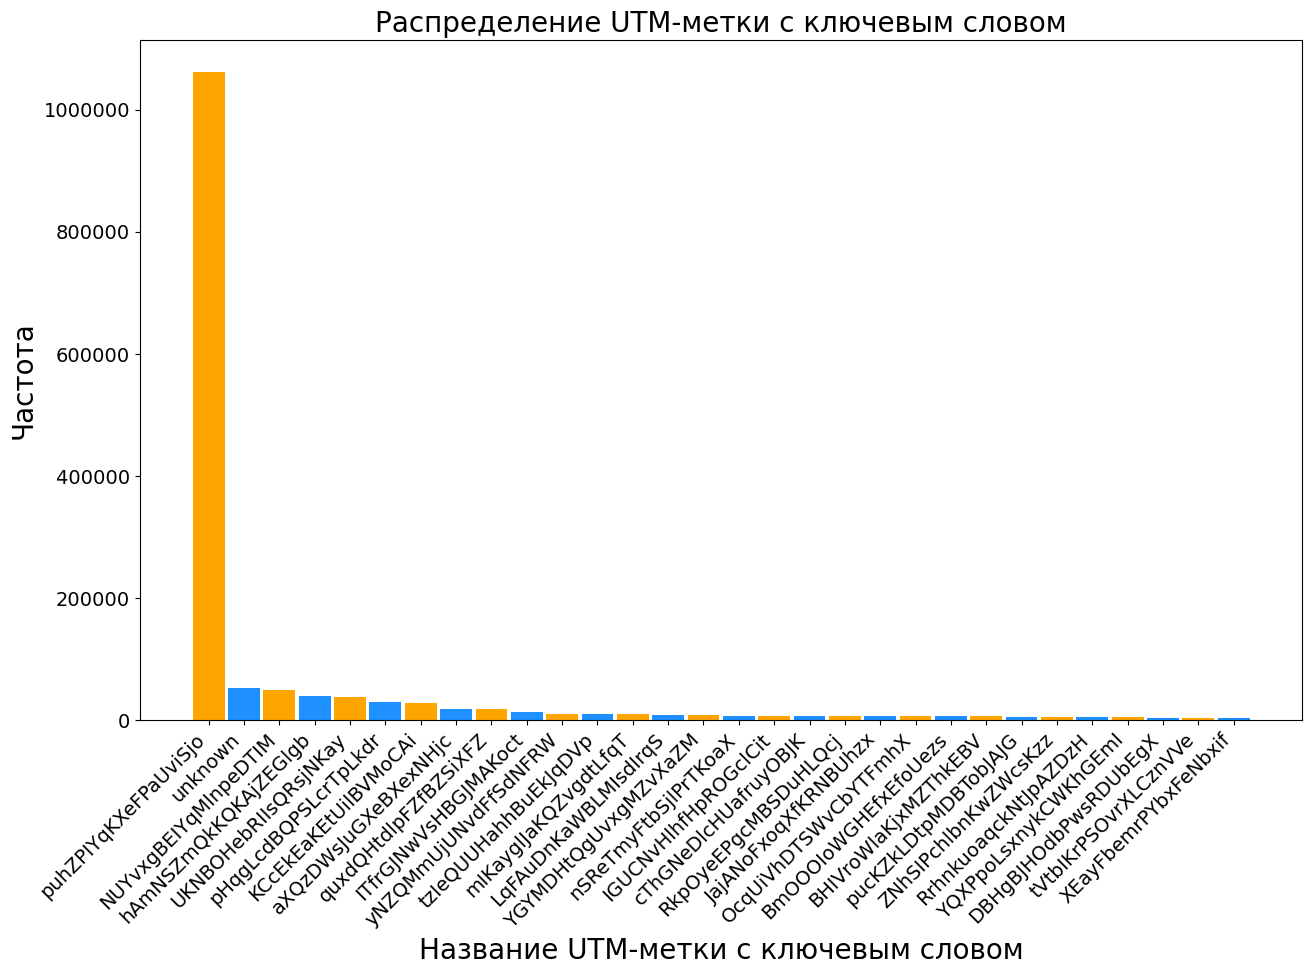

In [112]:
# График распределения для utm-меткок с ключевым словом(30 наиболее часто встречающихся)

distribution_graph(stats_keyword, 'utm_keyword', (15, 10), 'UTM-метки с ключевым словом', 30)

### UTM-метки с ключевым словом распределены неравномерно, около 3/4 представлены одним значением. Остальные значения встречаются в 2,5% случаев и менее (в разрезе отдельных значений).

In [55]:
# Статистики для столбца с информацией об операционной системе устройства

stats_os = feature_stats(df_full, 'device_os')
stats_os

,device_os,count
0,Android,842404
11,iOS,459801
9,Windows,280540
5,Macintosh,23414
4,Linux,4616
12,unknown,395
2,Chrome OS,65
1,BlackBerry,24
8,Tizen,7
3,Firefox OS,3


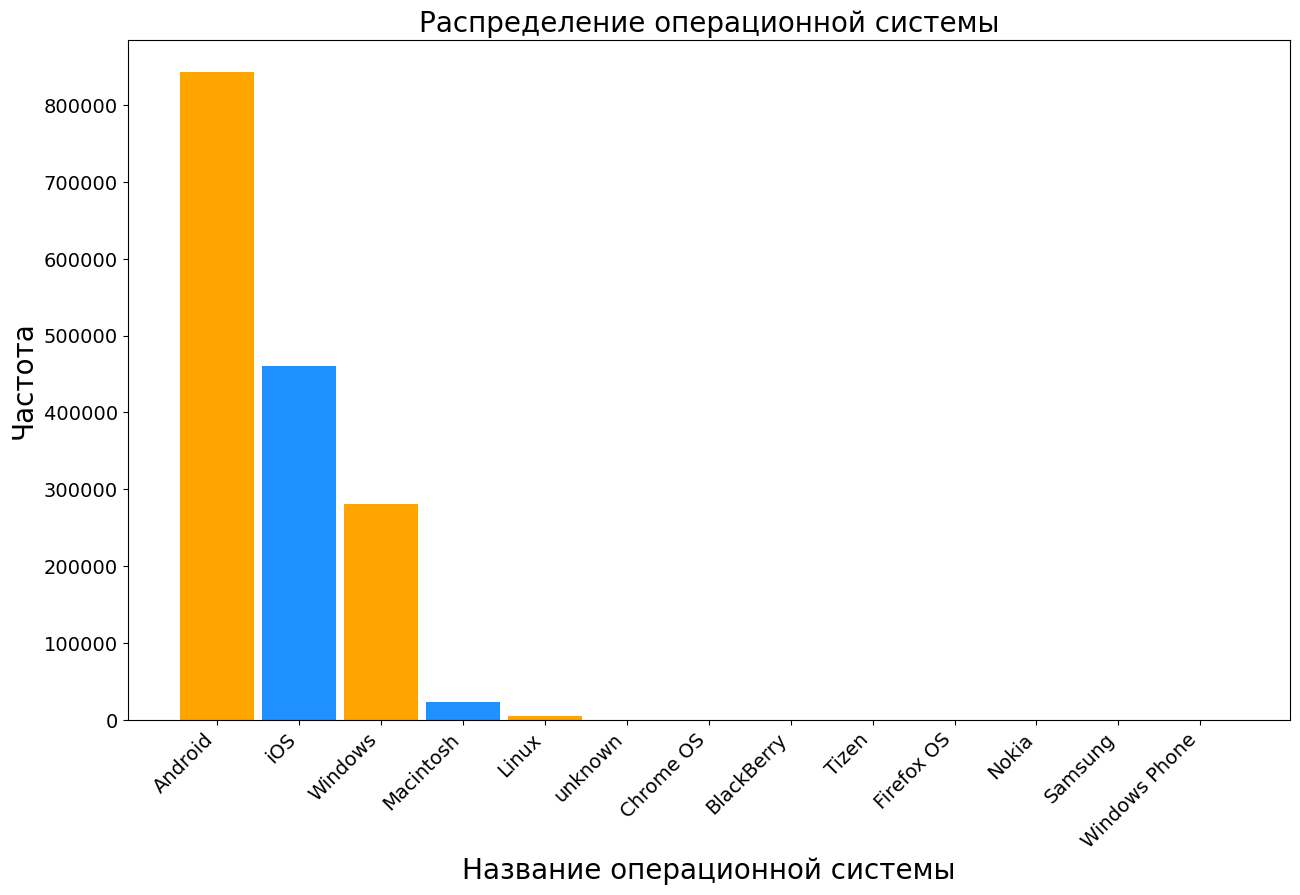

In [113]:
# График распределения для столбца с информацией об операционной системе устройства

distribution_graph(stats_os, 'device_os', (15, 10), 'операционной системы', 'all')

### Операционная система представлена 4 основными: Android, iOS, Windows, Macintoch. Другие встречаются менее чем в 1% случаев.

In [57]:
# Статистики для столбца с информацией о марке устройства

stats_brand = feature_stats(df_full, 'device_brand')
stats_brand.head(5)

,device_brand,count
9,Apple,483210
197,unknown,301508
142,Samsung,296983
188,Xiaomi,257952
75,Huawei,165981


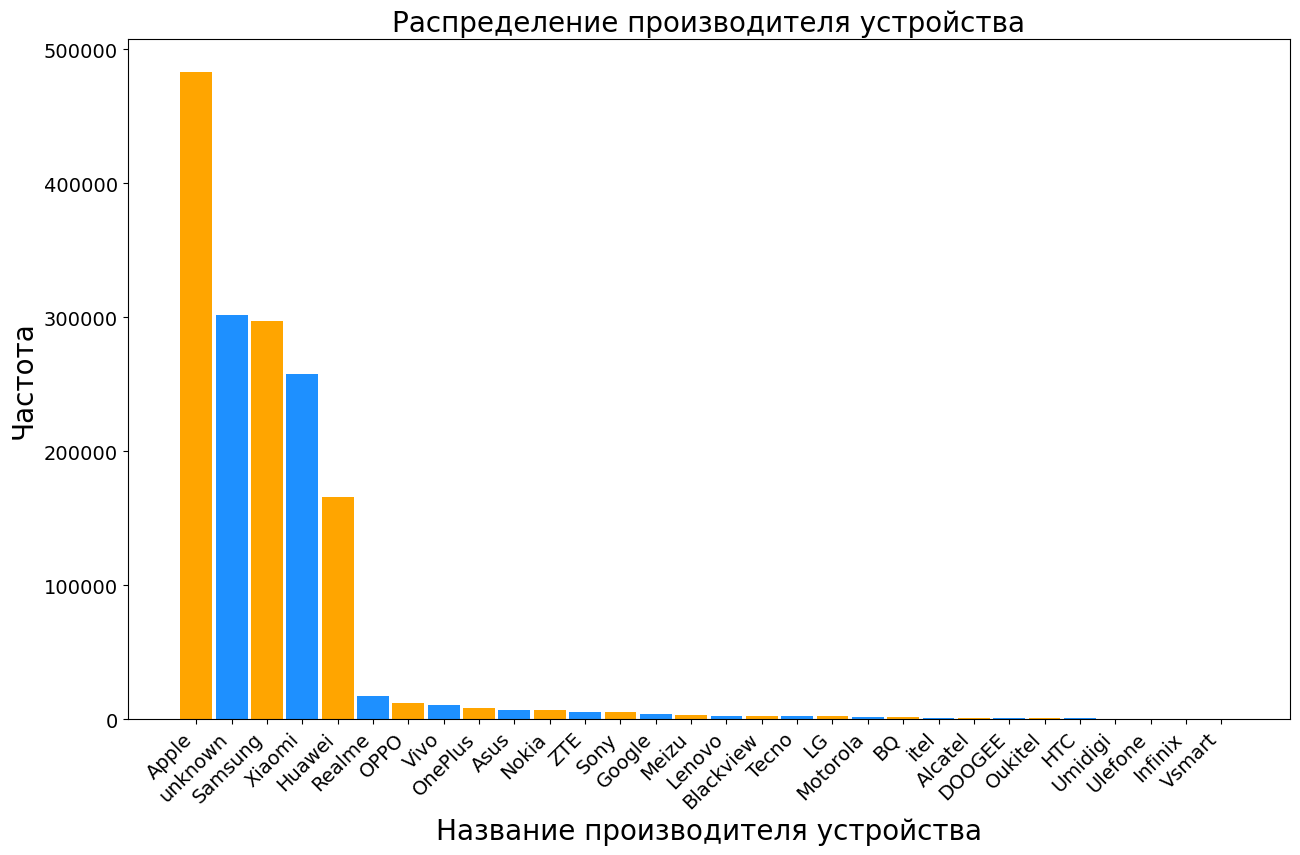

In [114]:
# График распределения марки устройства(30 наиболее часто встречающихся)

distribution_graph(stats_brand, 'device_brand', (15, 10), 'производителя устройства', 30)

### Бренды устройства распределены неравномерно, более 30% представлено одним производителем, еще 4 встречаются примерно в 18,5%, 18,5%, 16% и 11% случаев. Остальные значения встречаются менее чем в 1% случаев (в разрезе отдельных производителей).

In [59]:
# Статистики для столбца с информацией о категории устройства

stats_category = feature_stats(df_full, 'device_category')
stats_category

,device_category,count
1,mobile,1287362
0,desktop,308936
2,tablet,14977


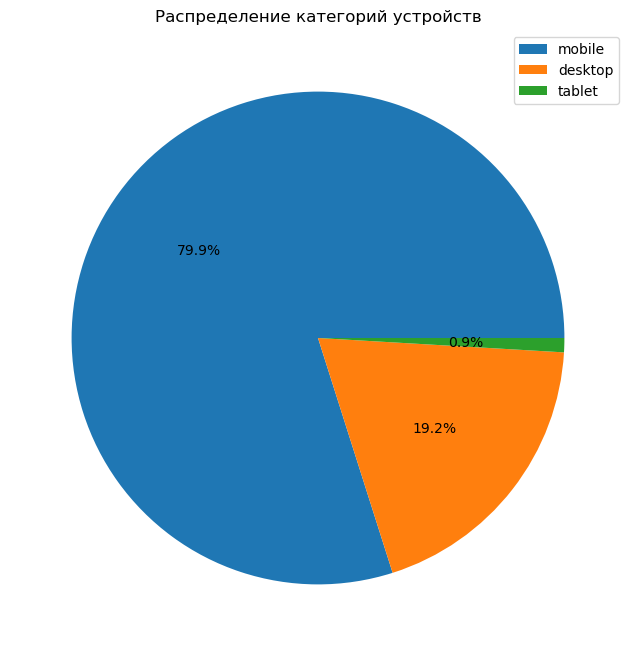

In [60]:
# График распределения категорий устройства

plt.figure(figsize=(12, 8))
plt.pie(stats_category['count'], labels=stats_category['device_category'], labeldistance=None, autopct = '%1.1f%%')
plt.title("Распределение категорий устройств")
plt.legend()
plt.show();

In [61]:
# Статистики для столбца с информацией о браузере устройства

stats_browser = feature_stats(df_full, 'device_browser')
stats_browser.head(5)

,device_browser,count
2,chrome,900102
19,safari,462046
24,yabrowser,106432
1,android,50610
20,samsung,41735


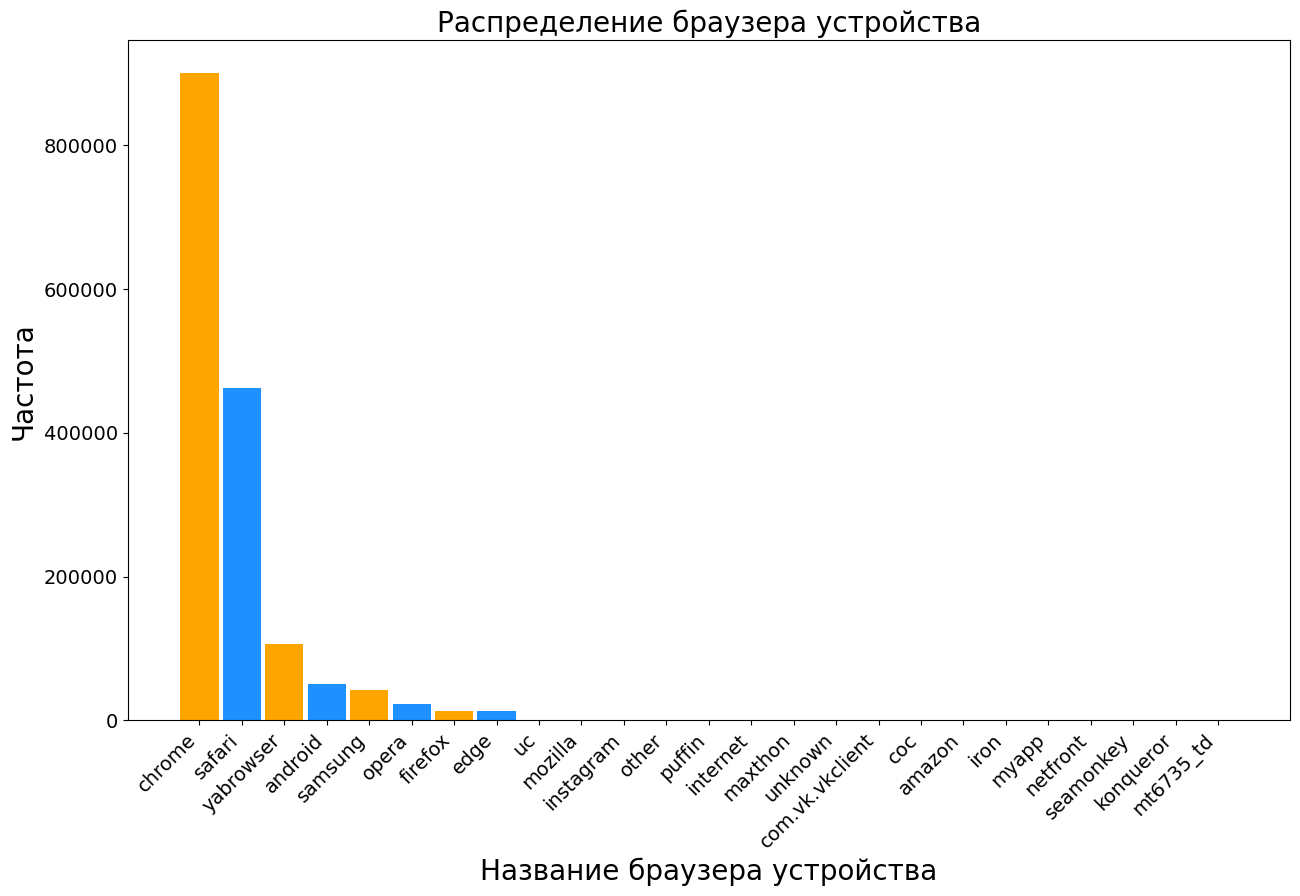

In [115]:
# График распределения категорий устройства

distribution_graph(stats_browser, 'device_browser', (15, 10), 'браузера устройства', 'all')

In [63]:
# Статистики для городов

stats_city = feature_stats(df_full, 'geo_city')
stats_city.head(5)

,geo_city,count
1320,Moscow,684887
1774,Saint Petersburg,252407
2338,unknown,66083
2282,Yekaterinburg,33029
1020,Krasnodar,29709


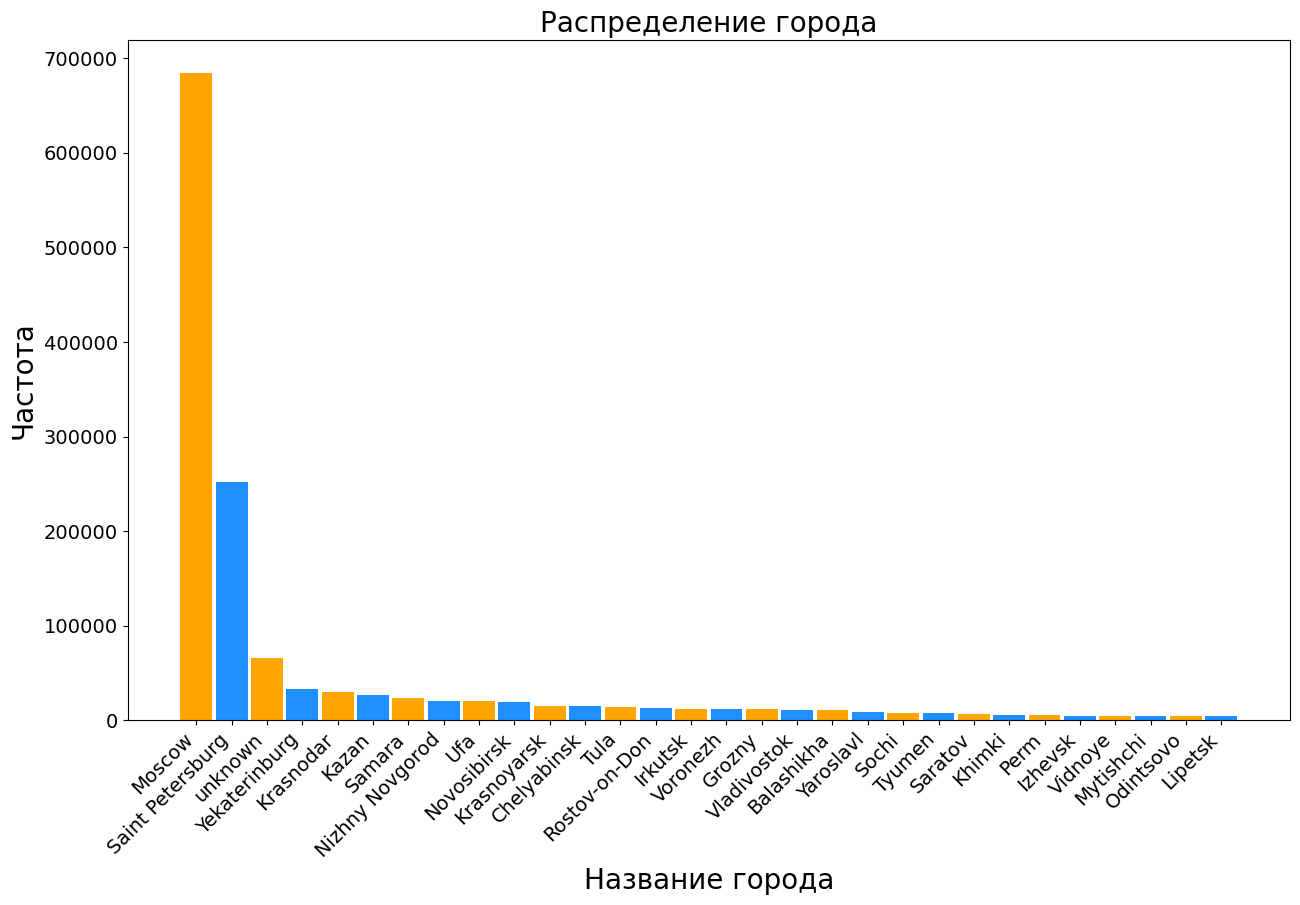

In [116]:
# График распределения городов

distribution_graph(stats_city, 'geo_city', (15, 10), 'города', 30)

### Около 42% клиентов находятся в Москве, 15,5 - в Санкт-Петербурге, для 4,5% город не определен. Остальные города представлены 2% и менее клиентов (для каждого города отдельно).

In [65]:
# Статистики для стран

stats_country = feature_stats(df_full, 'geo_country')
stats_country.head(5)

,geo_country,count
116,Russia,1563726
147,Ukraine,8201
150,United States,8008
15,Belarus,3148
70,Kazakhstan,2029


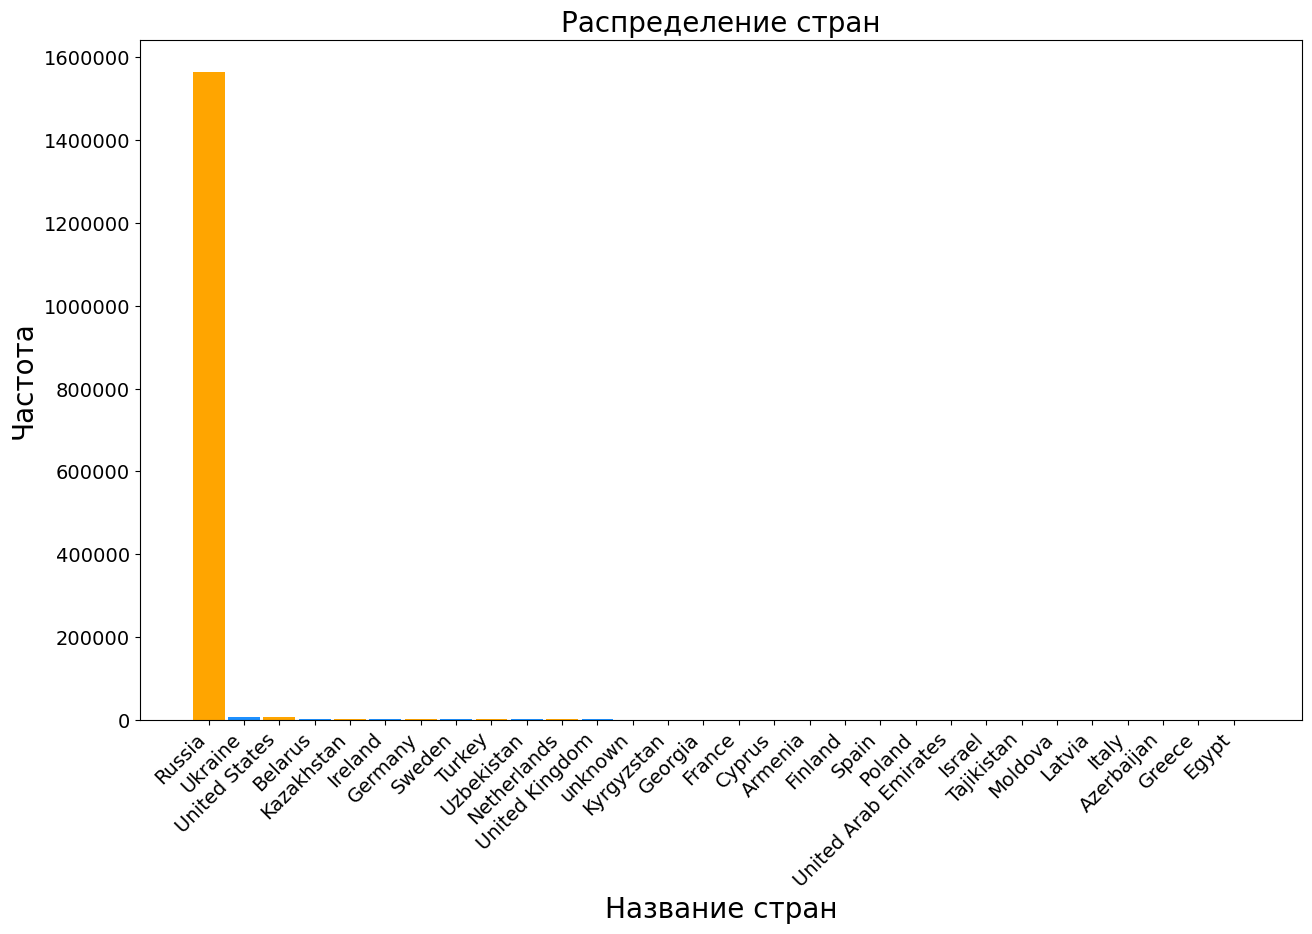

In [117]:
# График распределения стран

distribution_graph(stats_country, 'geo_country', (15, 10), 'стран', 30)

### 97% клиентов из России. Остальные страны представлены менее 1% клиентов (для каждого города отдельно).

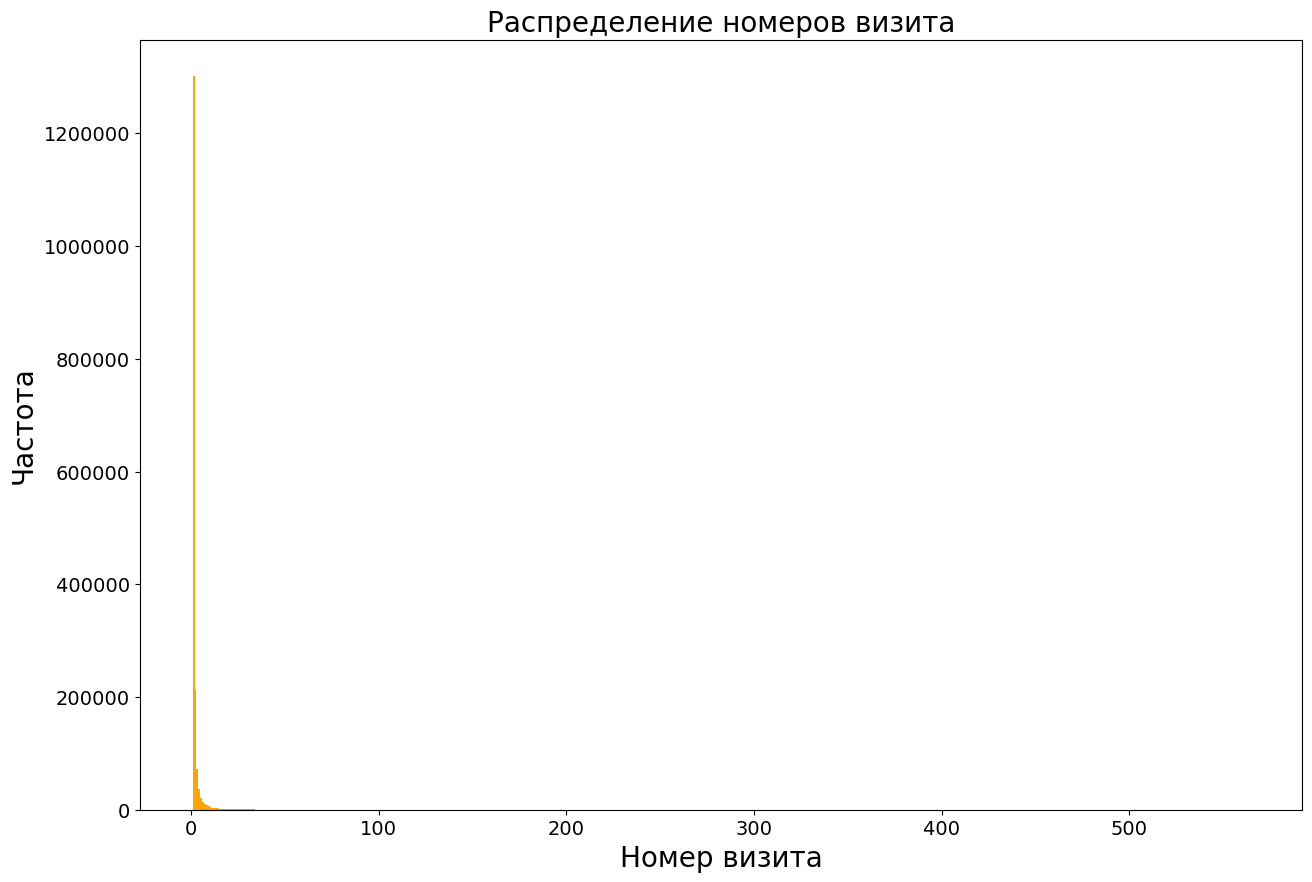

In [132]:
# График распределения порядкового номера визита

fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(df_full['visit_number'].values, bins=564, color=['orange'])
ax.set_xlabel('Номер визита', fontsize = 20)
ax.set_ylabel('Частота', fontsize = 20)
ax.set_title('Распределение номеров визита', fontsize = 20)
ax.tick_params(axis='both', labelsize=14)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [150]:
# Удаление неинформативных столбцов и запись датасета в файл для последующего обучения модели

df_full = df_full.drop(columns=['session_id', 'client_id'])
df_full.to_csv('sberpodpiska_data_prepared.csv', index=False)

In [ ]:
# Создание графика тепловой карты для отбражения корреляций

In [31]:
# Преобразование категориальных переменных с помощью TargetEncoder

data = ['utm_source', 'utm_campaign', 'utm_medium', 'utm_keyword', 'utm_adcontent', 'device_browser', 'device_os', 'device_brand', 'device_category', 'geo_country', 'geo_city']
encoder = TargetEncoder()
for elem in data:
     df_full[elem+'_encoding'] = encoder.fit_transform(df_full[elem], df_full['event_action_bin'])

C:\Users\Konstantin\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\Konstantin\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [34]:
# Удаление первоначальных признаков до преобразований

columns_for_drop = ['session_id', 'client_id', 'utm_source', 'utm_keyword', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_browser', 'device_os', 'device_category', 'geo_city', 'device_brand', 'geo_country', 'device_screen_resolution', 'visit_date', 'visit_time']
df_prepared = df_full.drop(columns=columns_for_drop)
df_prepared.head()

,visit_number,event_action_bin,utm_source_encoding,utm_campaign_encoding,utm_medium_encoding,utm_keyword_encoding,utm_adcontent_encoding,device_browser_encoding,device_os_encoding,device_brand_encoding,device_category_encoding,geo_country_encoding,geo_city_encoding
0,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.014151
1,1,0,0.012791,0.010415,0.010962,0.015396,0.012186,0.027555,0.027200,0.031692,0.027504,0.028546,0.030434
2,1,0,0.028953,0.029096,0.028764,0.033510,0.021796,0.028008,0.027200,0.025756,0.027504,0.028546,0.024566
3,1,0,0.023142,0.021807,0.019335,0.012324,0.012517,0.028008,0.027200,0.024136,0.027504,0.028546,0.030434
5,1,0,0.023142,0.044936,0.038176,0.053680,0.034894,0.028110,0.027956,0.028193,0.027504,0.028546,0.024690


In [35]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611275 entries, 0 to 1732265
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   visit_number              1611275 non-null  int64  
 1   event_action_bin          1611275 non-null  int64  
 2   utm_source_encoding       1611275 non-null  float64
 3   utm_campaign_encoding     1611275 non-null  float64
 4   utm_medium_encoding       1611275 non-null  float64
 5   utm_keyword_encoding      1611275 non-null  float64
 6   utm_adcontent_encoding    1611275 non-null  float64
 7   device_browser_encoding   1611275 non-null  float64
 8   device_os_encoding        1611275 non-null  float64
 9   device_brand_encoding     1611275 non-null  float64
 10  device_category_encoding  1611275 non-null  float64
 11  geo_country_encoding      1611275 non-null  float64
 12  geo_city_encoding         1611275 non-null  float64
dtypes: float64(11), int64(2)
me

In [36]:
df_prepared.corr()

,visit_number,event_action_bin,utm_source_encoding,utm_campaign_encoding,utm_medium_encoding,utm_keyword_encoding,utm_adcontent_encoding,device_browser_encoding,device_os_encoding,device_brand_encoding,device_category_encoding,geo_country_encoding,geo_city_encoding
visit_number,1.000000,0.027272,0.073648,0.071021,0.080099,0.046845,0.054414,0.016391,0.137700,0.063314,0.140734,0.007391,0.002898
event_action_bin,0.027272,1.000000,0.082829,0.091071,0.077245,0.070388,0.062968,0.011161,0.012417,0.021366,0.011440,0.016523,0.045381
utm_source_encoding,0.073648,0.082829,1.000000,0.687661,0.826950,0.461825,0.553016,0.078703,0.070779,0.054775,0.041343,-0.015149,0.016377
utm_campaign_encoding,0.071021,0.091071,0.687661,1.000000,0.664124,0.623106,0.562369,0.055052,0.053433,0.045115,0.022851,-0.013436,0.026121
utm_medium_encoding,0.080099,0.077245,0.826950,0.664124,1.000000,0.490036,0.487632,0.081770,0.127966,0.080879,0.103084,0.001104,0.023713
utm_keyword_encoding,0.046845,0.070388,0.461825,0.623106,0.490036,1.000000,0.631017,0.008744,-0.079613,-0.020054,-0.112152,-0.002125,0.028343
utm_adcontent_encoding,0.054414,0.062968,0.553016,0.562369,0.487632,0.631017,1.000000,0.012319,-0.050438,-0.010936,-0.098416,-0.017232,0.016479
device_browser_encoding,0.016391,0.011161,0.078703,0.055052,0.081770,0.008744,0.012319,1.000000,0.146347,0.058895,0.131176,0.026815,0.017210
device_os_encoding,0.137700,0.012417,0.070779,0.053433,0.127966,-0.079613,-0.050438,0.146347,1.000000,0.417600,0.902183,-0.001814,-0.012468
device_brand_encoding,0.063314,0.021366,0.054775,0.045115,0.080879,-0.020054,-0.010936,0.058895,0.417600,1.000000,0.442662,-0.001377,-0.006526


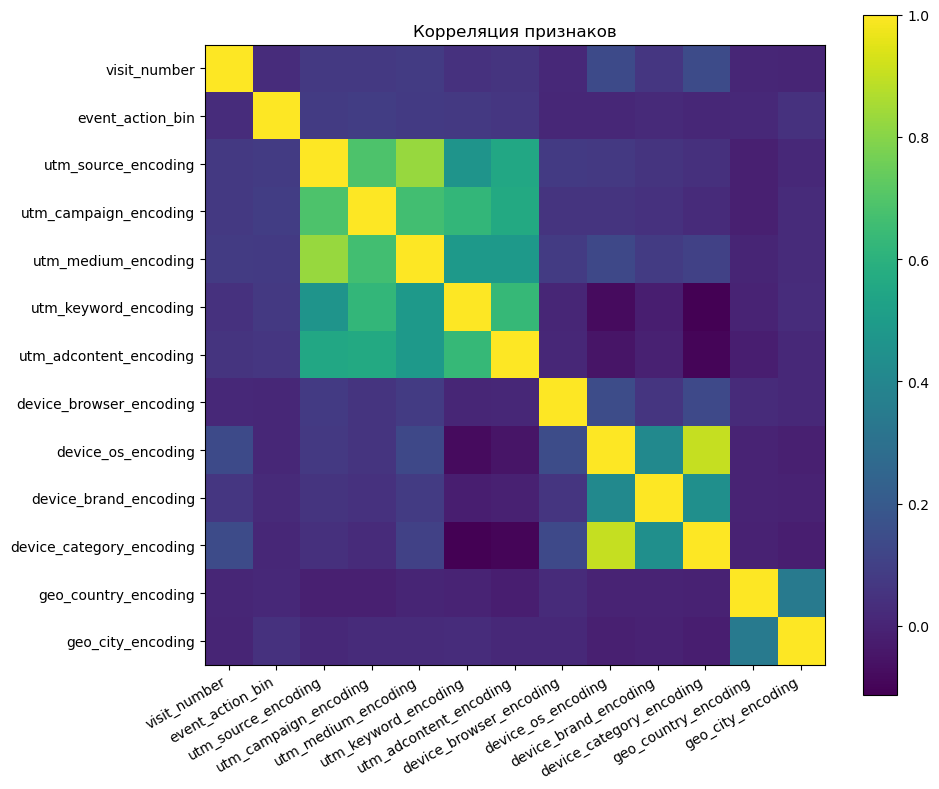

In [59]:
columns = df_prepared.corr().columns.tolist()

fig, ax = plt.subplots(figsize=(10, 10))
heatmap = ax.imshow(df_prepared.corr())
ax.set_xticks(range(0, len(columns)), columns)
ax.set_yticks(range(0, len(columns)), columns)
ax.set_title("Корреляция признаков")
fig.colorbar(heatmap)
fig.autofmt_xdate(rotation=30);

### На тепловой карте видна сильная корреляция признаков UTM-меток, а также признаков, характерезующих устройство и географическое положение. 

### Это говорит о задействовании в рамках отдельных рекламных компаний определенных ресурсов и каналов рекламы, как следствие корреляция признаков с доп.информацией (вероятно уточнение конкретной ссылки или расположения рекламы на ресурсе) и ключевого слова с остальными метками.

### Корреляция категории устройства и операционной системы, а также других признаков устройств, объясняется тем, что, в основном, каждой категории, как и бренду соответствует ограниченное количество или одна операционная система. Аналогично паре признаков город-страна.